In [1]:
from htm.bindings.sdr import SDR, Metrics
from htm.encoders.scalar_encoder import ScalarEncoder, ScalarEncoderParameters
from htm.encoders.date import DateEncoder
from htm.algorithms import SpatialPooler
from htm.bindings.algorithms import TemporalMemory
from htm.algorithms.anomaly_likelihood import AnomalyLikelihood
import numpy as np
import pandas as pd
import pathlib
import datetime
import csv
from tqdm import tqdm
import copy
import matplotlib.pyplot as plt
import hashlib

In [2]:
class ReflexiveMemory:
  def __init__(self, dimensions):
    self.previous_sdr = None
    self.pairs = {}
    self.dimensions = dimensions

  def add(self, sdr):
    current_sdr = '-'.join(map(str, sdr.sparse))
    if(self.previous_sdr != None):
      values = self.pairs.get(self.previous_sdr, {})
      pair_count = values.get(current_sdr, 0)
      pair_count = pair_count + 1
      if self.pairs.get(self.previous_sdr, None) is None:
        self.pairs[self.previous_sdr] = { current_sdr: pair_count }
      else:
        self.pairs[self.previous_sdr][current_sdr] = pair_count
    self.previous_sdr = current_sdr

  def predict(self, sdr):
    search_sdr = '-'.join(map(str, sdr.sparse))
    values = self.pairs.get(search_sdr, {})
    return_value = 0
    return_key = None
    for key, value in values.items():
      if value > return_value:
        return_value = value
        return_key = key
    if return_key is not None:
      return_sdr = SDR( self.dimensions )
      return_sdr.sparse = list(map(int, return_key.split('-')))
      return_key = return_sdr
    return return_value, return_key

  # Control Unit
  def learn(self, sdr):
    pred_correct = False
    pred_anomaly = None
    if self.previous_sdr is not None:
        prev_activeColumns = SDR( self.dimensions )
        prev_activeColumns.sparse = list(map(int, self.previous_sdr.split('-')))

        pred_value, pred_key = self.predict(prev_activeColumns)
        if pred_key is not None:
            if pred_key.flatten() == sdr.flatten():
                pred_correct = True
                pred_anomaly = 0
            else:
                key1 = self.previous_sdr
                key2 = '-'.join(map(str, pred_key.sparse))
                self.pairs[key1][key2] = pred_value - 1
                
                pred_anomaly = 1 - np.count_nonzero((pred_key.dense & sdr.dense)) / np.count_nonzero(pred_key.dense)

    return pred_correct, pred_anomaly



In [3]:
inputSources = [
    "hourly_numentaTM_speed_7578.csv",
    "hourly_numentaTM_iio_us-east-1_i-a2eb1cd9_NetworkIn.csv",
    "hourly_numentaTM_exchange-3_cpc_results.csv",
    "hourly_numentaTM_exchange-3_cpm_results.csv",
    "hourly_numentaTM_exchange-2_cpc_results.csv",
    "hourly_numentaTM_exchange-2_cpm_results.csv",
    "hourly_numentaTM_exchange-4_cpc_results.csv",
    "hourly_numentaTM_exchange-4_cpm_results.csv",
    "hourly_numentaTM_rogue_agent_key_hold.csv",
    "hourly_numentaTM_TravelTime_451.csv",
    "hourly_numentaTM_occupancy_6005.csv",
    "hourly_numentaTM_speed_t4013.csv",
    "hourly_numentaTM_TravelTime_387.csv",
    "hourly_numentaTM_occupancy_t4013.csv",
    "hourly_numentaTM_speed_6005.csv",
    "hourly_numentaTM_art_daily_flatmiddle.csv",
    "hourly_numentaTM_art_daily_jumpsdown.csv",
    "hourly_numentaTM_art_daily_jumpsup.csv",
    "hourly_numentaTM_art_daily_no_noise.csv",
    "hourly_numentaTM_art_daily_nojump.csv",
    "hourly_numentaTM_art_daily_perfect_square_wave.csv",
    "hourly_numentaTM_art_daily_small_noise.csv",
    "hourly_numentaTM_art_flatline.csv",
    "hourly_numentaTM_art_increase_spike_density.csv",
    "hourly_numentaTM_art_load_balancer_spikes.csv",
    "hourly_numentaTM_art_noisy.csv",
    "hourly_numentaTM_ec2_cpu_utilization_24ae8d.csv",
    "hourly_numentaTM_ec2_cpu_utilization_53ea38.csv",
    "hourly_numentaTM_ec2_cpu_utilization_5f5533.csv",
    "hourly_numentaTM_ec2_cpu_utilization_77c1ca.csv",
    "hourly_numentaTM_ec2_cpu_utilization_825cc2.csv",
    "hourly_numentaTM_ec2_cpu_utilization_ac20cd.csv",
    "hourly_numentaTM_ec2_cpu_utilization_c6585a.csv",
    "hourly_numentaTM_ec2_cpu_utilization_fe7f93.csv",
    "hourly_numentaTM_ec2_disk_write_bytes_c0d644.csv",
    "hourly_numentaTM_ec2_network_in_257a54.csv",
    "hourly_numentaTM_ec2_request_latency_system_failure.csv",
    "hourly_numentaTM_elb_request_count_8c0756.csv",
    "hourly_numentaTM_rds_cpu_utilization_cc0c53.csv",
    "hourly_numentaTM_rds_cpu_utilization_e47b3b.csv",
    "hourly_numentaTM_grok_asg_anomaly.csv",
    "hourly_numentaTM_ec2_disk_write_bytes_1ef3de.csv",
    "hourly_numentaTM_ec2_network_in_5abac7.csv",
    "hourly_numentaTM_rogue_agent_key_updown.csv",
    "hourly_numentaTM_ambient_temperature_system_failure.csv",
    "hourly_numentaTM_nyc_taxi.csv",
    "hourly_numentaTM_Twitter_volume_AMZN.csv",
    "hourly_numentaTM_Twitter_volume_FB.csv",
    "hourly_numentaTM_Twitter_volume_GOOG.csv",
    "hourly_numentaTM_Twitter_volume_KO.csv",
    "hourly_numentaTM_Twitter_volume_CVS.csv",
    "hourly_numentaTM_Twitter_volume_PFE.csv",
    "hourly_numentaTM_Twitter_volume_UPS.csv",
    "hourly_numentaTM_Twitter_volume_IBM.csv",
    "hourly_numentaTM_Twitter_volume_AAPL.csv",
    "hourly_numentaTM_Twitter_volume_CRM.csv",
    "hourly_numentaTM_cpu_utilization_asg_misconfiguration.csv",
    "hourly_numentaTM_machine_temperature_system_failure.csv",
#    "value1_pseudo_periodic_synthetic_1.csv",
#    "value1_pseudo_periodic_synthetic_2.csv",
#    "value1_pseudo_periodic_synthetic_3.csv",
#    "value1_pseudo_periodic_synthetic_4.csv",
#    "value1_pseudo_periodic_synthetic_5.csv",
#    "value1_pseudo_periodic_synthetic_6.csv",
#    "value1_pseudo_periodic_synthetic_7.csv",
#    "value1_pseudo_periodic_synthetic_8.csv",
#    "value1_pseudo_periodic_synthetic_9.csv",
#    "value1_pseudo_periodic_synthetic_10.csv",
#    "monthly_gold_prices.csv",
#    "monthly_sp500.csv",
#    "weekly_dow_jones.csv",
#    "weekly_nasdaq.csv",
#    "weekly_sp500.csv",
#    "monthly_vix_close.csv",
#    "monthly_vix_high.csv",
#    "monthly_vix_low.csv",
#    "monthly_vix_open.csv",
#    "daily_natural_gas.csv",
#    "daily_oil_prices.csv",
#    "value1_vix_close.csv",
#    "value1_vix_high.csv",
#    "value1_vix_low.csv",
#    "value1_vix_open.csv"
]

In [4]:

config = {
    'enc': {
        "value" :
            {'size': 700, 'activeBits': 41, 'minimum': None, 'maximum': None},
        "time": 
            {'timeOfDay': (30, 1), 'weekend': 21}
    },
    'sp': {
        'inputDimensions': None,
        'columnDimensions': (1638,),
        'potentialPct': 0.85,
        'potentialRadius': None,
        'globalInhibition': True,
        'localAreaDensity': 0.04395604395604396,
        'synPermInactiveDec': 0.006,
        'synPermActiveInc': 0.04,
        'synPermConnected': 0.13999999999999999,
        'boostStrength': 3.0,
        'wrapAround': True,
        'seed': 1,
        'learn': False,
    },
    'tm': {
        'cellsPerColumn': 13,
        'activationThreshold': 17,
        'initialPermanence': 0.21,
        'minThreshold': 10,
        'maxNewSynapseCount': 32,
        'permanenceIncrement': 0.1,
        'permanenceDecrement': 0.1,
        'predictedSegmentDecrement': 0.0,
        'maxSegmentsPerCell': 128,
        'maxSynapsesPerSegment': 64,
        'learn': True
    },
    'anomaly': {'period': 1000},
    'learnRows': 100
}


In [5]:
input_path = pathlib.Path('../datasets/numenta')

pbar = tqdm(total=len(inputSources))
for dataset in inputSources:

    records = []
    with open(input_path.joinpath(dataset), "r") as fin:
        reader = csv.reader(fin)
        headers = next(reader)
        next(reader)
        next(reader)
        for record in reader:
            records.append(record)
    
    dateEncoder = DateEncoder(
        timeOfDay= config["enc"]["time"]["timeOfDay"], 
        weekend  = config["enc"]["time"]["weekend"]
    )

    config["enc"]["value"]["minimum"] = min(float(r[1]) for r in records)
    config["enc"]["value"]["maximum"] = max(float(r[1]) for r in records)
    
    scalarEncoderParams = ScalarEncoderParameters()
    scalarEncoderParams.activeBits = config["enc"]["value"]["activeBits"]
    scalarEncoderParams.minimum = config["enc"]["value"]["minimum"]
    scalarEncoderParams.maximum = config["enc"]["value"]["maximum"]
    scalarEncoderParams.size = config["enc"]["value"]["size"]
    scalarEncoder = ScalarEncoder( scalarEncoderParams )
    # encodingWidth = (dateEncoder.size + scalarEncoder.size)
    encodingWidth = (scalarEncoder.size)


    config['sp']['inputDimensions'] = (encodingWidth,)
    config['sp']['potentialRadius'] = encodingWidth

    sp = SpatialPooler(
        inputDimensions = config['sp']['inputDimensions'],
        columnDimensions = config['sp']['columnDimensions'],
        potentialPct = config['sp']['potentialPct'],
        potentialRadius = config['sp']['potentialRadius'],
        globalInhibition = config['sp']['globalInhibition'],
        localAreaDensity = config['sp']['localAreaDensity'],
        synPermInactiveDec = config['sp']['synPermInactiveDec'],
        synPermActiveInc = config['sp']['synPermActiveInc'],
        synPermConnected = config['sp']['synPermConnected'],
        boostStrength = config['sp']['boostStrength'],
        wrapAround = config['sp']['wrapAround'],
        seed = config['sp']['seed']
    )

    tm = TemporalMemory(
        columnDimensions = config['sp']['columnDimensions'],
        cellsPerColumn = config['tm']['cellsPerColumn'],
        activationThreshold = config['tm']['activationThreshold'],
        initialPermanence = config['tm']['initialPermanence'],
        connectedPermanence = config['sp']['synPermConnected'],
        minThreshold = config['tm']['minThreshold'],
        maxNewSynapseCount = config['tm']['maxNewSynapseCount'],
        permanenceIncrement = config['tm']['permanenceIncrement'],
        permanenceDecrement = config['tm']['permanenceDecrement'],
        predictedSegmentDecrement = config['tm']['predictedSegmentDecrement'],
        maxSegmentsPerCell = config['tm']['maxSegmentsPerCell'],
        maxSynapsesPerSegment = config['tm']['maxSynapsesPerSegment']
    )

    rm = ReflexiveMemory( sp.getColumnDimensions() )

    enc_info = Metrics( [encodingWidth], 999999999)
    sp_info = Metrics( sp.getColumnDimensions(), 999999999 )
    tm_info = Metrics( [tm.numberOfCells()], 999999999 )
    anomaly_history = AnomalyLikelihood(config["anomaly"]["period"])

    inputs = []
    anomaly = []
    anomalyProb = []
    anomalyRM = []
    for count, record in enumerate(records):

        dateString = datetime.datetime.strptime(record[0], "%Y-%m-%d %H:%M:%S")
        consumption = float(record[1])
        inputs.append( consumption )
        
        dateBits = dateEncoder.encode(dateString)
        consumptionBits = scalarEncoder.encode(consumption)

        # encoding = SDR( encodingWidth ).concatenate([consumptionBits, dateBits])
        encoding = SDR( consumptionBits )
        enc_info.addData( encoding )
        
        activeColumns = SDR( sp.getColumnDimensions() )

        if count < config['learnRows']:

            sp.compute(encoding, True, activeColumns)
            sp_info.addData( activeColumns )

            tm.compute(activeColumns, learn=True)
            tm_info.addData( tm.getActiveCells().flatten() )

        else: 

            sp.compute(encoding, config['sp']['learn'], activeColumns)
            sp_info.addData( activeColumns )

            pred_correct, pred_anomaly = rm.learn(activeColumns)
            anomalyRM.append( pred_anomaly )
            rm.add(activeColumns)

            tm.compute(activeColumns, learn=config['tm']['learn'])
            tm_info.addData( tm.getActiveCells().flatten() )

        anomaly.append( tm.anomaly )
        anomalyProb.append( anomaly_history.compute(tm.anomaly) )

    pbar.update(1)
    break

pbar.close()




  2%|▏         | 1/58 [00:01<01:08,  1.21s/it]


In [6]:
print("Encoded Input", enc_info)

Encoded Input SDR( 700 )
    Sparsity Min/Mean/Std/Max 0.0585714 / 0.0585716 / 6.87395e-07 / 0.0585714
    Activation Frequency Min/Mean/Std/Max 0 / 0.0585714 / 0.126567 / 0.548445
    Entropy 0.587491
    Overlap Min/Mean/Std/Max 0 / 0.414287 / 0.347593 / 1


In [7]:
print("Spatial Pooler Mini-Columns", sp_info)
print(str(sp))

Spatial Pooler Mini-Columns SDR( 1638 )
    Sparsity Min/Mean/Std/Max 0.043956 / 0.0439559 / 3.43303e-07 / 0.043956
    Activation Frequency Min/Mean/Std/Max 0 / 0.043956 / 0.0538288 / 0.423111
    Entropy 0.821529
    Overlap Min/Mean/Std/Max 0 / 0.159215 / 0.298461 / 1
Spatial Pooler Connections:
    Inputs (700) ~> Outputs (1638) via Segments (1638)
    Segments on Cell Min/Mean/Max 1 / 1 / 1
    Potential Synapses on Segment Min/Mean/Max 595 / 595 / 595
    Connected Synapses on Segment Min/Mean/Max 257 / 296.946 / 335
    Synapses Dead (0.0867814%) Saturated (0.00700588%)
    Synapses pruned (0%) Segments pruned (0%)
    Buffer for destroyed synapses: 0    Buffer for destroyed segments: 0



In [8]:
print(dataset)

hourly_numentaTM_speed_7578.csv


In [9]:
print("Temporal Memory Cells", tm_info)
print(str(tm))


Temporal Memory Cells SDR( 21294 )
    Sparsity Min/Mean/Std/Max 0.00338123 / 0.0244095 / 0.0155513 / 0.043956
    Activation Frequency Min/Mean/Std/Max 0 / 0.0244098 / 0.0260959 / 0.261333
    Entropy 0.878011
    Overlap Min/Mean/Std/Max 0 / 0.0488885 / 0.109847 / 0.909091
Temporal Memory Connections:
    Inputs (12438) ~> Outputs (21294) via Segments (24354)
    Segments on Cell Min/Mean/Max 0 / 1.1437 / 8
    Potential Synapses on Segment Min/Mean/Max 32 / 45.3848 / 64
    Connected Synapses on Segment Min/Mean/Max 27 / 39.8979 / 64
    Synapses Dead (0%) Saturated (0.0294969%)
    Synapses pruned (0.0951415%) Segments pruned (0%)
    Buffer for destroyed synapses: 0    Buffer for destroyed segments: 0



In [10]:
  print("Anomaly Mean", np.mean(anomaly))
  print("Anomaly Std ", np.std(anomaly))

Anomaly Mean 0.483851851657033
Anomaly Std  0.41810025546138246


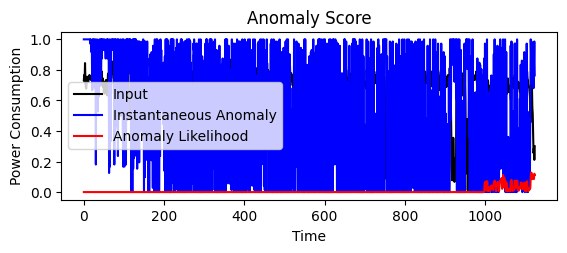

In [11]:
plt.subplot(2,1,2)
plt.title("Anomaly Score")
plt.xlabel("Time")
plt.ylabel("Power Consumption")
inputs = np.array(inputs) / max(inputs)
plt.plot(np.arange(len(inputs)), inputs, 'black',
            np.arange(len(inputs)), anomaly, 'blue',
            np.arange(len(inputs)), anomalyProb, 'red',)
plt.legend(labels=('Input', 'Instantaneous Anomaly', 'Anomaly Likelihood'))
plt.show()


In [12]:
for key1, value1 in rm.pairs.items():
    for key2, value2 in value1.items():
        if value2 > 1:
            result = hashlib.md5(key1.encode())
            print(result.hexdigest(), end=' ')
            result = hashlib.md5(key2.encode())
            print(result.hexdigest(), end=' ')
            print(value2)

dda4aefd484909f18c6576d7c236a009 dc8f85552555eafc00552e50c15c95a0 2
1cf841747ef58c8b20509fbe51ea8722 a3f0d4c922961b372815f100f2c25b76 3
484ade5cd6f0a3b5e1663a28acb3a854 a05fa3f66b8339f375ec6f8c6a5b7ee0 3
f6749765e1705dc514a062ad4b7ca211 3021e204840567d91f888db56b639e7c 2
f6749765e1705dc514a062ad4b7ca211 9229170c3f0e7395ac7eb010f8e5edb2 2
dc8f85552555eafc00552e50c15c95a0 dc8f85552555eafc00552e50c15c95a0 2
a05fa3f66b8339f375ec6f8c6a5b7ee0 dc8f85552555eafc00552e50c15c95a0 2
9c316cabee0132ac9411948849ede717 dc8f85552555eafc00552e50c15c95a0 3


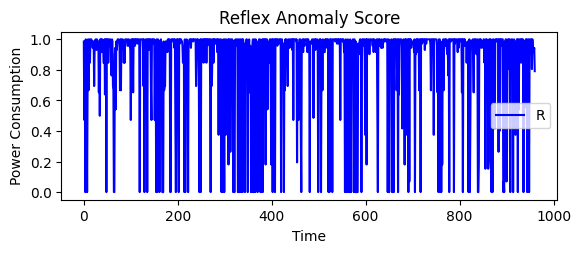

In [13]:
anomalyRM = [x for x in anomalyRM if x is not None]

plt.subplot(2,1,2)
plt.title("Reflex Anomaly Score")
plt.xlabel("Time")
plt.ylabel("Power Consumption")
plt.plot(np.arange(len(anomalyRM)), anomalyRM, 'blue')
plt.legend(labels=('Reflex Anomaly'))
plt.show()
